In [1]:
import codecs
import json
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib
import seaborn as sns
import numpy as np
import venn
import itertools
import networkx as nx
import re

In [2]:
with codecs.open("../data/merger.min.json", "r", "utf8") as file:
    rows = json.load(file)["entries"]
    
with codecs.open("../data/stopwords.txt", "r", "utf8") as file:
    stopwords = set(map(lambda s: s.strip(), file.readlines()))

In [3]:
sns.set()

sns.set_style("white")

font = {'family' : 'Consolas', 'size': 60}
matplotlib.rc('font', **font)
plt.rcParams.update({'font.size': 60})
SMALL_SIZE = 30
MEDIUM_SIZE = 40
BIGGER_SIZE = 60

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

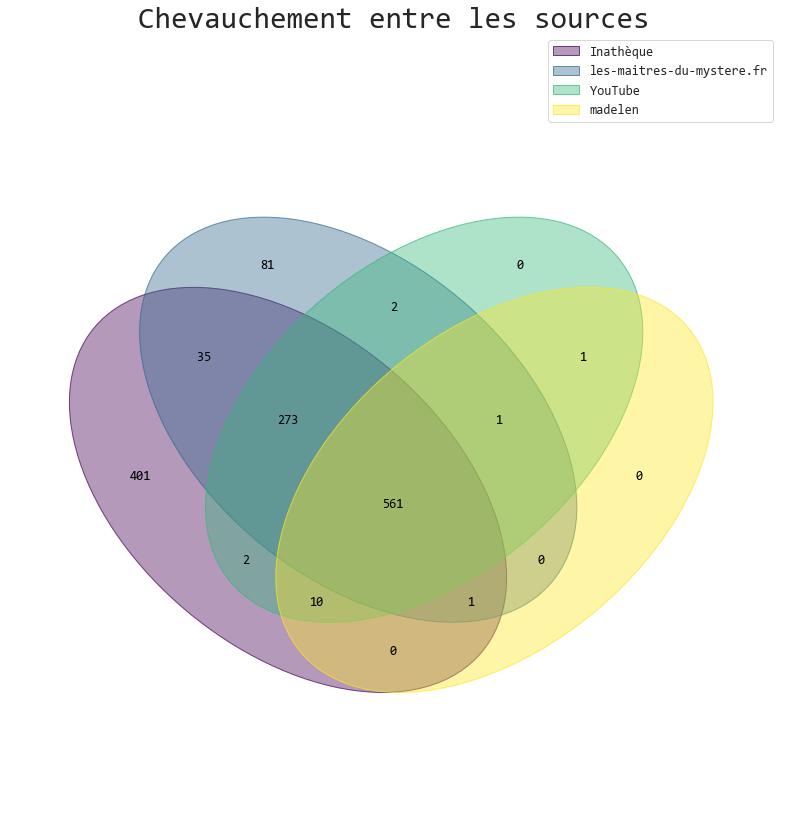

In [4]:
venn_data = {
    "inatheque_uri": set(),
    "madelen_uri": set(),
    "lmdmfr_uri": set(),
    "youtube_uri": set()
}

for row in rows:
    for col in venn_data:
        if row["links"][col] is not None:
            venn_data[col].add(row["doc_id"])

venn_data["Inathèque"] = venn_data.pop("inatheque_uri")
venn_data["les-maitres-du-mystere.fr"] = venn_data.pop("lmdmfr_uri")
venn_data["YouTube"] = venn_data.pop("youtube_uri")
venn_data["madelen"] = venn_data.pop("madelen_uri")

venn.venn(venn_data, figsize=(12, 12))
plt.title("Chevauchement entre les sources")
plt.tight_layout()
matplotlib.pyplot.savefig("venn.svg")
pass

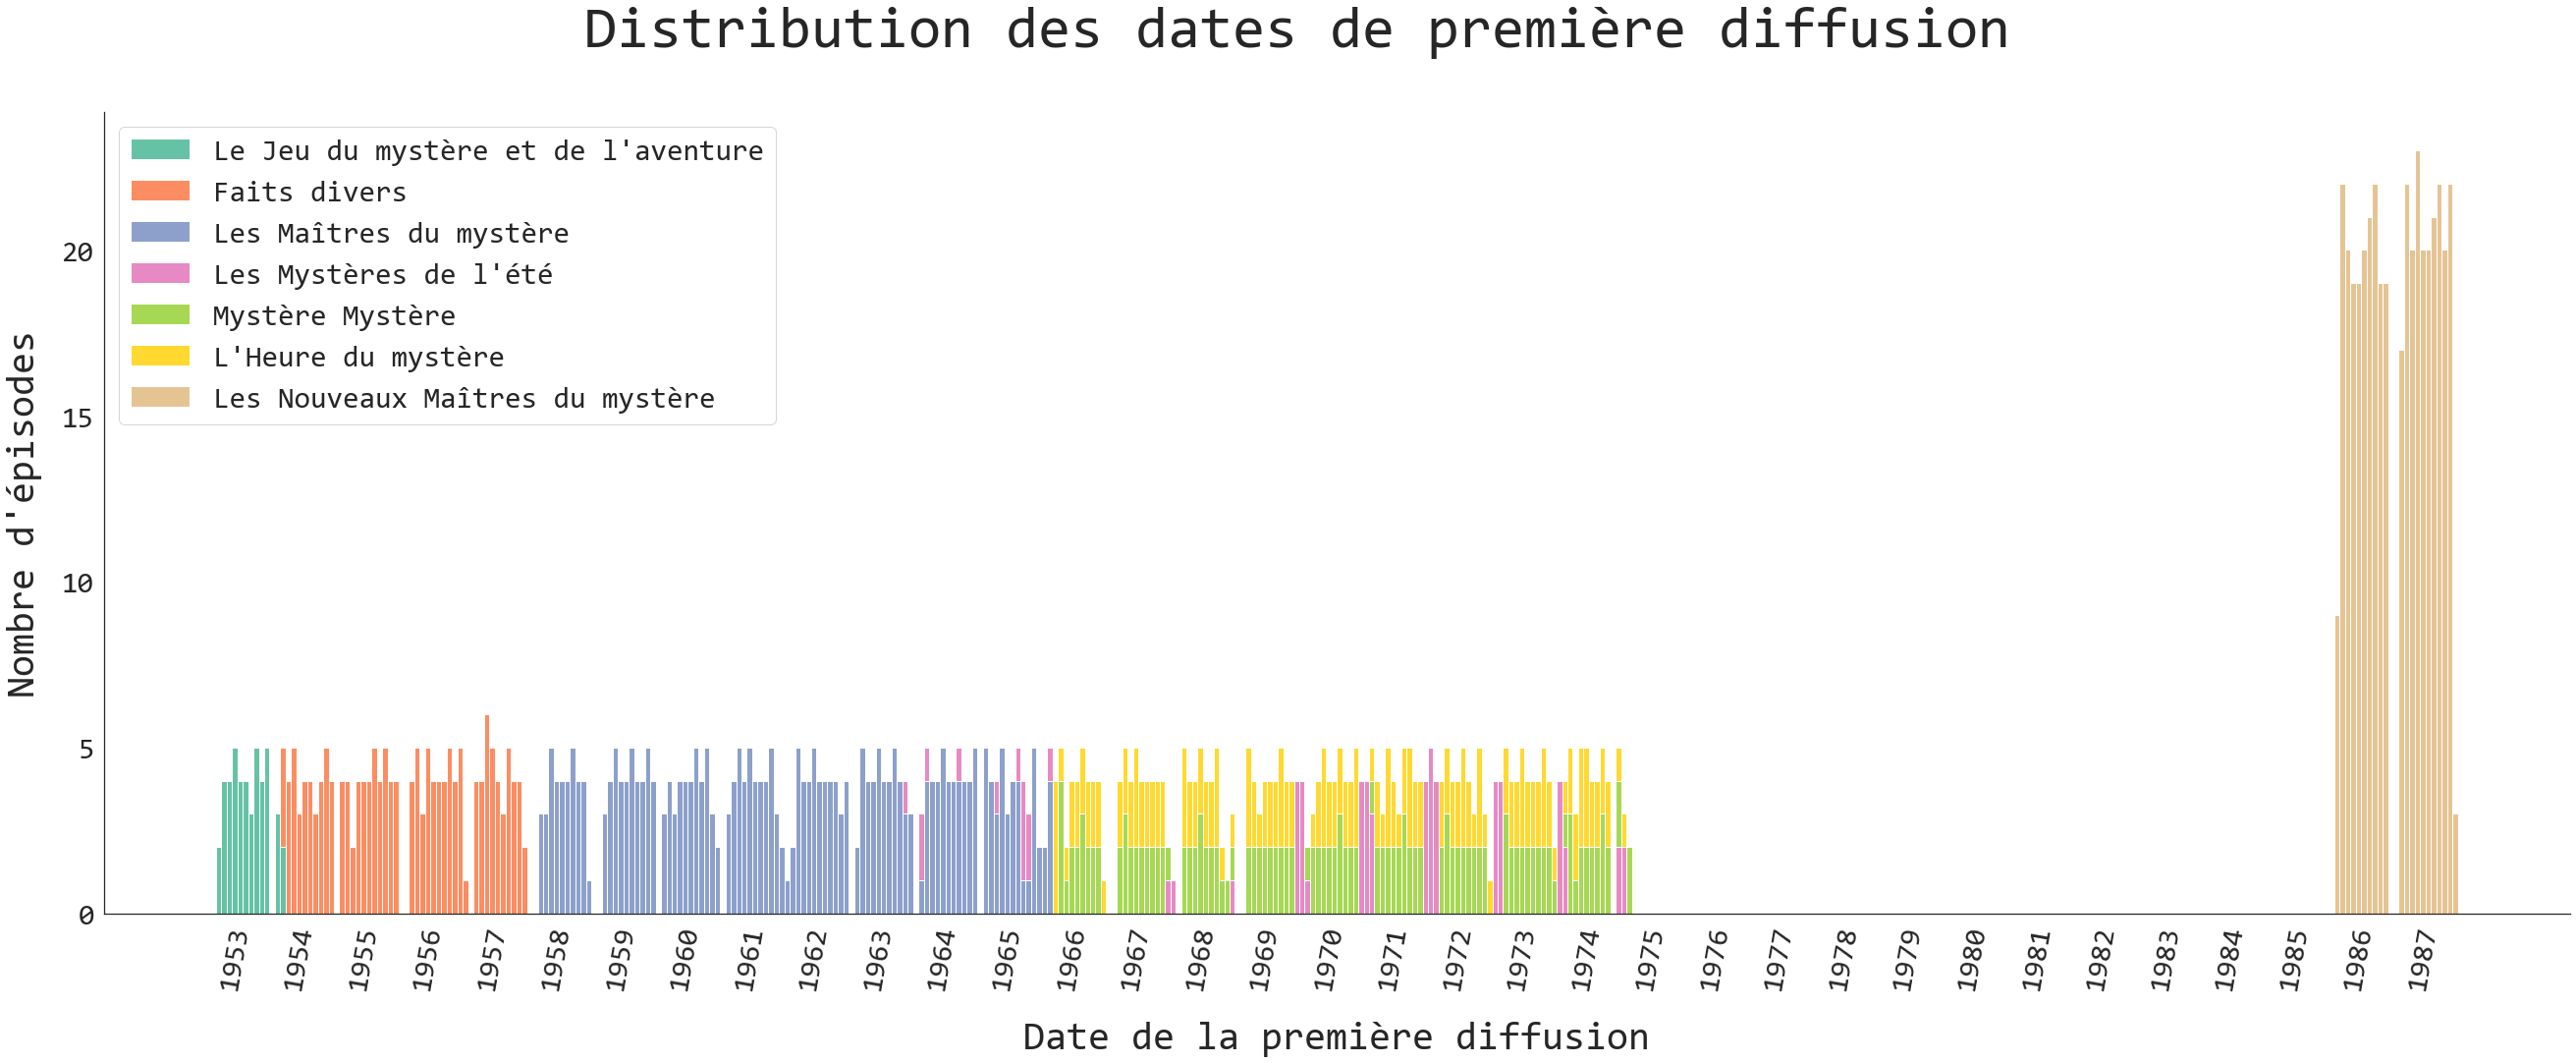

In [5]:
series_with_date = list()
for row in rows:
    if row["diffusion_date"] is None or row["collection"] is None:
        continue
    series_with_date.append((row["diffusion_date"], row["collection"]))


fig = plt.figure(figsize=(45, 15), constrained_layout=False)
gs = GridSpec(1, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

months_per_collection = dict()
months = set()
for date, collection in series_with_date:
    month = date[:7]
    collection = collection\
        .replace("Les maîtres du mystère", "Les Maîtres du mystère")\
        .replace("Les mystères de l'été", "Les Mystères de l'été")\
        .replace("Le jeu du mystère et de l'aventure", "Le Jeu du mystère et de l'aventure")
    months.add(month)
    months_per_collection.setdefault(collection, dict())
    months_per_collection[collection].setdefault(month, 0)
    months_per_collection[collection][month] += 1

min_year, min_month = map(int, min(months).split("-"))
max_year, max_month = map(int, max(months).split("-"))
months_range = [(min_year, min_month)]
while True:
    cur_year, cur_month = months_range[-1]
    next_year = cur_year
    next_month = cur_month + 1
    if next_month == 13:
        next_month = 1
        next_year += 1
    if next_year < max_year or next_month <= max_month:
        months_range.append((next_year, next_month))
    else:
        break
for i in range(len(months_range)):
    months_range[i] = "%d-%02d" % months_range[i]

# hls
palette = sns.color_palette("Set2", len(months_per_collection))
width = 1
total_heights = [0 for _ in months_range]
hatch_patterns = itertools.cycle([" "])

for collection, color in zip(["Le Jeu du mystère et de l'aventure", "Faits divers", "Les Maîtres du mystère", "Les Mystères de l'été", "Mystère Mystère", "L'Heure du mystère", "Les Nouveaux Maîtres du mystère"], palette):
    month_dict = months_per_collection[collection]
    height = [month_dict.get(month, 0) for month in months_range]
    ax1.bar(months_range, height=height, width=width, label=collection, color=color, hatch=next(hatch_patterns), bottom=total_heights)
    for i, h in enumerate(height):
        total_heights[i] += h
        

tick_every = 12
ticks = list()
ticks_labels = list()
for i in range(3, len(months_range), tick_every):
    ticks.append(i)
    ticks_labels.append(months_range[i][:4])
    
fig.suptitle("Distribution des dates de première diffusion")
ax1.set_ylabel("Nombre d'épisodes", labelpad=20)
ax1.set_xlabel("Date de la première diffusion", labelpad=30)
ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks_labels, rotation=80)
ax1.legend()
# plt.tight_layout()
sns.despine()
plt.savefig("hist.svg")

In [6]:
authors = dict()
for row in rows:
    if row["credits"]["author"] is not None:
        authors.setdefault(row["credits"]["author"], 0)
        authors[row["credits"]["author"]] += 1
top_n = 20
print(f"Top {top_n} auteurs\n" + "\n".join(map(str, sorted(authors.items(), key=lambda x: -x[1])[:top_n])))
print(f"\nsur un total de {len(authors)}")

Top 20 auteurs
('Charles Maitre', 60)
('Louis Thomas Cervioni', 51)
('Jeannine Raylambert', 48)
('Francis Didelot', 41)
('Alain Franck', 40)
('Jean-Pierre Ferrière', 39)
('Eric Assous', 35)
('Jean Marcillac', 30)
('Georges-Gabriel Bomier', 28)
('Louis Rognoni', 28)
('Jacques Fayet', 25)
('Pierre Frachet', 23)
('Henri Crespi', 22)
('Roger Maridat', 22)
('Fred Kassak', 20)
('Alain Krief', 20)
('Robert Nahmias', 18)
('Jean Chatenet', 17)
('André Delaure', 17)
('Roger Faller', 14)

sur un total de 314


Top 20 Interprètes
('Gaétan Jor', 182)
('Pierre Delbon', 151)
('Jean-Pierre Lituac', 143)
('Jean Bolo', 138)
('Geneviève Morel', 127)
('Marie-Jeanne Gardien', 123)
('Rosy Varte', 120)
('Henri Poirier', 119)
('André Var', 107)
('Lisette Lemaire', 105)
('Jean-Marie Fertey', 102)
('Jacqueline Rivière', 101)
('Jean-Claude Michel', 94)
('Arlette Thomas', 94)
('Henri Virlojeux', 92)
('André Valmy', 90)
('Jean Péméja', 89)
('Yves Duchateau', 88)
('Jean Mauvais', 86)
('Raymond Pelissier', 85)

Top 20 Duos d'interprètes
(('Gaétan Jor', 'Jean Bolo'), 98)
(('Gaétan Jor', 'Yves Duchateau'), 88)
(('Gaétan Jor', 'Geneviève Morel'), 88)
(('Jean Bolo', 'Jean-Pierre Lituac'), 86)
(('Geneviève Morel', 'Jean Bolo'), 84)
(('Gaétan Jor', 'Henri Virlojeux'), 80)
(('Gaétan Jor', 'Jean-Pierre Lituac'), 72)
(('Gaétan Jor', 'Lisette Lemaire'), 72)
(('Gaétan Jor', 'Pierre Delbon'), 70)
(('Jean Bolo', 'Yves Duchateau'), 68)
(('Geneviève Morel', 'Yves Duchateau'), 68)
(('Gaétan Jor', 'Raymond Pelissier'), 68)
(('G

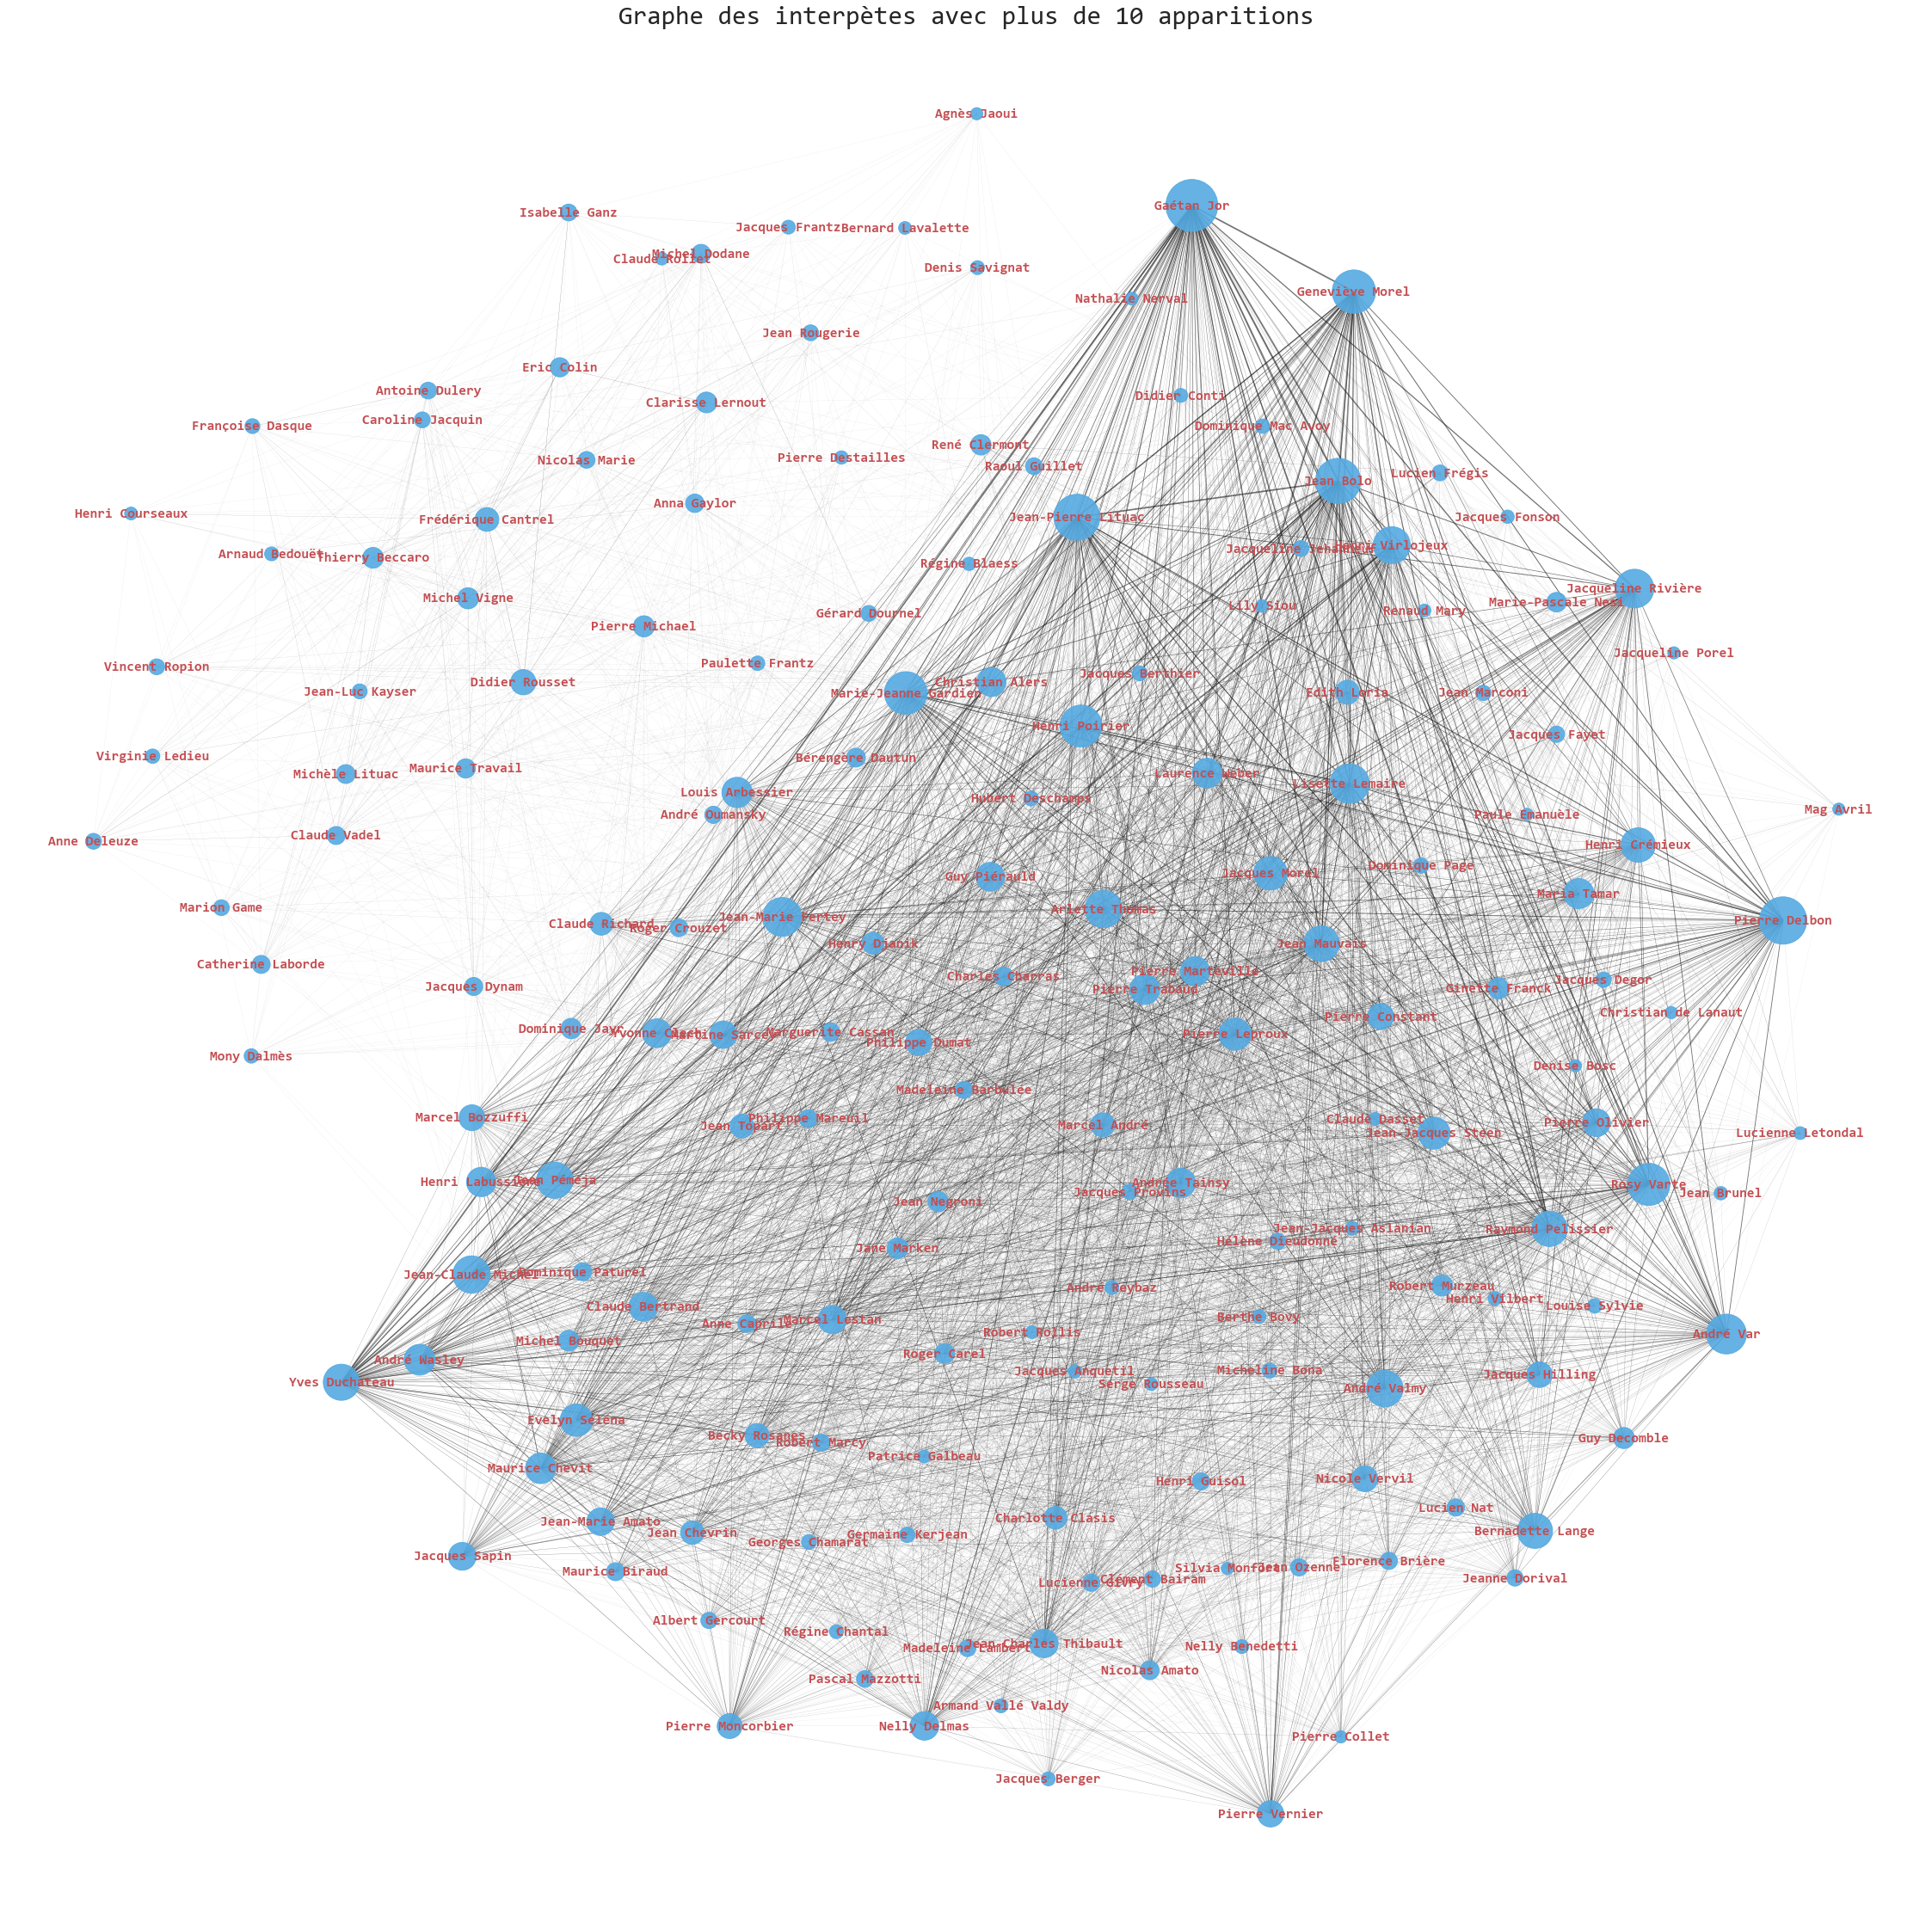

In [7]:
node_threshold = 10

cast_graph_nodes = dict()
cast_graph_edges = dict()
for row in rows:
    for actor in row["credits"]["cast"]:
        cast_graph_nodes.setdefault(actor["name"], 0)
        cast_graph_nodes[actor["name"]] += 1
        for mate in row["credits"]["cast"]:
            if actor["name"] == mate["name"]:
                continue
            edge = tuple(sorted([actor["name"], mate["name"]]))
            cast_graph_edges.setdefault(edge, 0)
            cast_graph_edges[edge] += 1
cast_graph = nx.Graph()
for u, w in sorted(cast_graph_nodes.items(), key=lambda x: x[1]):
    if cast_graph_nodes[u] < node_threshold:
        continue
    cast_graph.add_node(u, weight=cast_graph_nodes[u])
for (u, v), w in cast_graph_edges.items():
    if cast_graph_nodes[u] < node_threshold or cast_graph_nodes[v] < node_threshold:
        continue
    cast_graph.add_edge(u, v, weight=w)

# plt.figure(figsize=(40, 40))
# plt.hist(cast_graph_nodes.values(), bins=100)

palette = sns.color_palette("Set2", 1)

top_n = 20

node_size  = [20 * cast_graph_nodes[u] for u in cast_graph.nodes]
edge_width = [0.02 * cast_graph_edges[tuple(sorted(e))] for e in cast_graph.edges]

print(f"Top {top_n} Interprètes\n" + "\n".join(map(str, sorted(cast_graph_nodes.items(), key=lambda x: -x[1])[:top_n])))

print(f"\nTop {top_n} Duos d'interprètes\n" + "\n".join(map(str, sorted(cast_graph_edges.items(), key=lambda x: -x[1])[:top_n])))

plt.figure(figsize=(40, 40))
pos = nx.kamada_kawai_layout(cast_graph, scale=1)
nx.draw_networkx_edges(cast_graph, pos, alpha=0.6, width=edge_width)
nx.draw_networkx_nodes(cast_graph, pos, node_size=node_size, alpha=0.9, node_color="#55aae2")
nx.draw_networkx_labels(cast_graph, pos, font_family="Consolas", font_color="r", font_weight="bold", font_size=16)
plt.title(f"Graphe des interpètes avec plus de {node_threshold} apparitions")
sns.despine(left=True, bottom=True)
plt.savefig("cast.svg")

In [8]:
crew_graph_nodes = dict()

for row in rows:
    for actor in row["credits"]["crew"]:
        crew_graph_nodes.setdefault(actor["name"], 0)
        crew_graph_nodes[actor["name"]] += 1

print(f"Top {top_n} Crew\n" + "\n".join(map(str, sorted(crew_graph_nodes.items(), key=lambda x: -x[1])[:top_n])))

Top 20 Crew
('Germaine Beaumont', 267)
('Roger Régent', 258)
('Jean Bériac', 122)
('Maurice Renault', 90)
('Pierre Véry', 88)
('Jean Toscane', 42)
('Gabriel de Rivage', 41)
('Jean Deloron', 32)
('Charles Maitre', 28)
('Pierre Billard', 27)
('Jean Chatenet', 25)
('Jean Cosmos', 24)
('Jean Godet', 18)
('Roger Richard', 16)
('Jean Grimod', 14)
('Jean-Jacques Noël', 11)
('Pierre Rolland', 10)
('Michel Averlant', 9)
('Jeannine Raylambert', 8)
('Maurice-Bernard Endrèbe', 7)


In [9]:
descriptors_graph_nodes = dict()

for row in rows:
    for actor in row["descriptors"]:
        descriptors_graph_nodes.setdefault(actor["label"], 0)
        descriptors_graph_nodes[actor["label"]] += 1

print(f"Top {top_n} Descripteurs\n" + "\n".join(map(str, sorted(descriptors_graph_nodes.items(), key=lambda x: -x[1])[:top_n])))

Top 20 Descripteurs
('roman policier', 304)
('film', 287)
('meurtre', 149)
('fait divers', 121)
('enquête de police', 106)
('adultère', 53)
('chantage', 45)
('héritage', 34)
('pièce de théâtre', 27)
('crime', 25)
('escroquerie', 24)
('vengeance', 24)
('jalousie', 23)
('argent', 22)
('famille', 20)
('amour', 18)
('accident', 17)
('suicide', 16)
('roman', 15)
('vol-infraction', 13)


In [10]:
relevant_words_graph_nodes = dict()

for row in rows:
    for actor in row["relevant_words"]:
        relevant_words_graph_nodes.setdefault(actor["label"], 0)
        relevant_words_graph_nodes[actor["label"]] += 1

print(f"Top {top_n} relevant_words\n" + "\n".join(map(str, sorted(relevant_words_graph_nodes.items(), key=lambda x: -x[1])[:top_n])))

Top 20 relevant_words
('simone', 14)
('pascal', 12)
('brigadier', 11)
('sophie', 11)
('elisabeth', 10)
('micheline', 10)
('bruno', 10)
('antoine', 10)
('colette', 10)
('mathilde', 10)
('atelier', 10)
('solange', 10)
('christine', 10)
('daniel', 10)
('patrick', 10)
('agnès', 10)
('monique', 10)
('comte', 9)
('brigitte', 9)
('serge', 9)


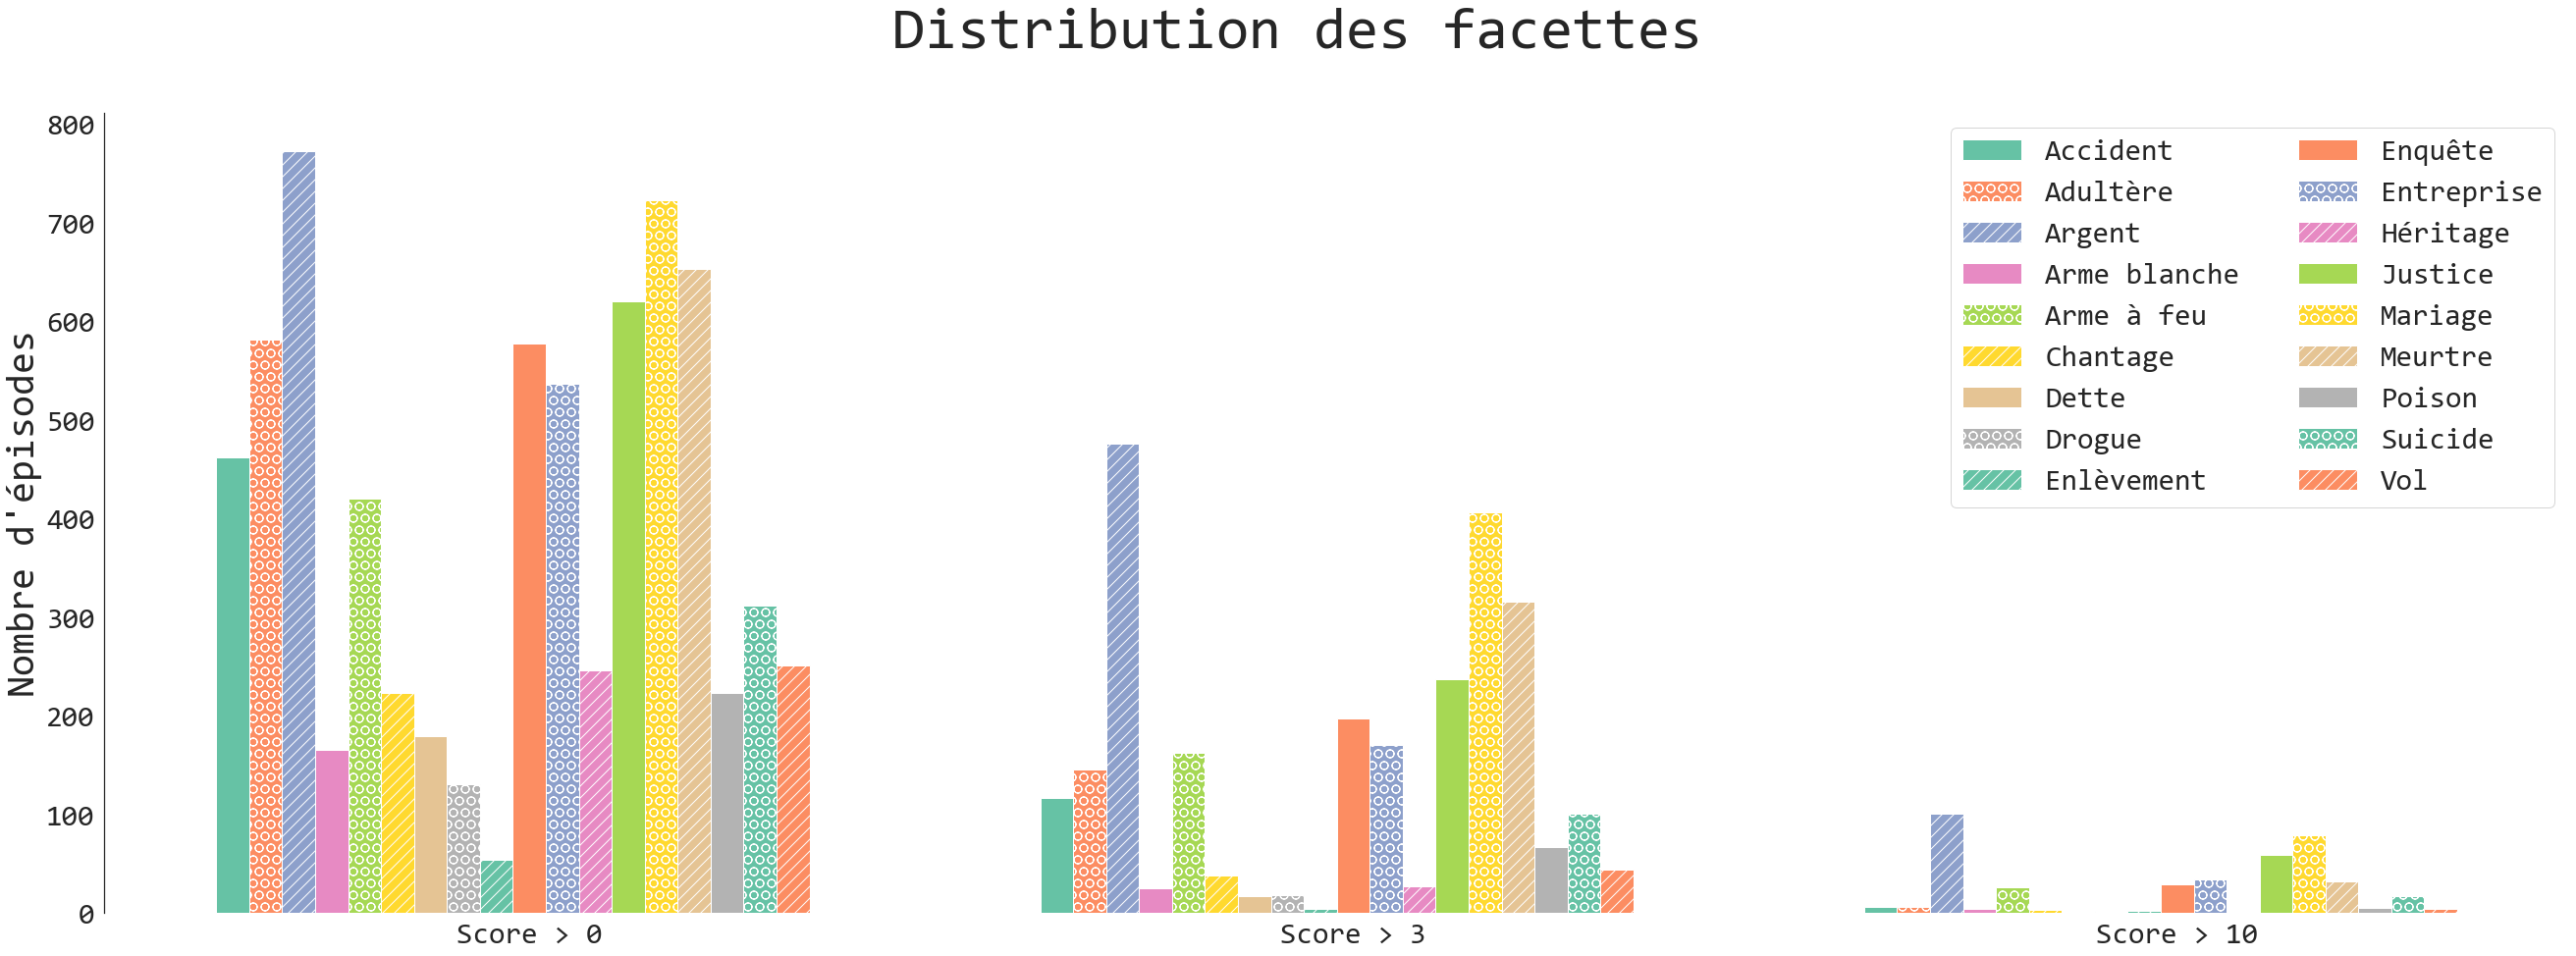

In [11]:
facets_a = dict()
facets_b = dict()
facets_c = dict()
for row in rows:
    for facet in row["facets"]:
        facets_a.setdefault(facet["label"], 0)
        facets_b.setdefault(facet["label"], 0)
        facets_c.setdefault(facet["label"], 0)
        if facet["score"] > 0:
            facets_a[facet["label"]] += 1
        if facet["score"] > 3:
            facets_b[facet["label"]] += 1
        if facet["score"] > 10:
            facets_c[facet["label"]] += 1

plt.figure(figsize=(45, 15))
labels = sorted(facets_a)
width = 1.

palette = sns.color_palette("Set2", len(labels))
hatch_patterns = itertools.cycle([" ", "O", "//"])

offset = 0
spacing = 7 * width

for i, (label, color, pattern) in enumerate(zip(labels, palette, hatch_patterns)):
    plt.bar(
        x=[offset, len(labels) * width + spacing + offset, (len(labels) * width + spacing) * 2 + offset],
        height=[facets_a[label], facets_b[label], facets_c[label]],
        label=label,
        width=width,
        color=color,
        hatch=pattern
    )
    offset += width

# plt.hist(facets.values(), label=list(facets.keys()), log=True)
plt.legend(loc="upper right", ncol=2)
# plt.xlabel("Score de l'aspect")
plt.ylabel("Nombre d'épisodes")

offset = 0.5 * len(labels) * width
plt.xticks(
    [offset, len(labels) * width + spacing + offset, (len(labels) * width + spacing) * 2 + offset],
    labels=["Score > 0", "Score > 3", "Score > 10"]
)
plt.suptitle("Distribution des facettes")

# plt.tight_layout()
sns.despine(bottom=True)
plt.savefig("facets.svg")

In [12]:
titles = list()
titles_words = dict()
for row in rows:
    titles.append(row["title"].lower())
    for word in re.split("[' ]", titles[-1]):
        if word in stopwords:
            continue
        titles_words.setdefault(word, 0)
        titles_words[word] += 1
sorted(titles_words.items(), key=lambda x: -x[1])[:20]

[('mort', 60),
 ('homme', 19),
 ('deux', 19),
 ('crime', 17),
 ('monsieur', 16),
 ('petit', 13),
 ('nuit', 13),
 ('affaire', 13),
 ('rendez-vous', 12),
 ('plus', 12),
 ('dernière', 12),
 ('meurtre', 11),
 ('amour', 11),
 ('morte', 11),
 ('tête', 10),
 ('trois', 10),
 ('vérité', 9),
 ('madame', 9),
 ('feu', 9),
 ('rien', 9)]

In [13]:
stopwords_plus = {
    "qu",
    "lui",
    "se",
    "s",
    ";",
    "c"
}

pitches = list()
pitches_words = dict()
for row in rows:
    if row["summary"]["pitch"] is None:
        continue
    pitches.append(row["summary"]["pitch"].lower())
    for word in re.split("[' ]", pitches[-1]):
        if word in stopwords.union(stopwords_plus):
            continue
        pitches_words.setdefault(word, 0)
        pitches_words[word] += 1
sorted(pitches_words.items(), key=lambda x: -x[1])[:20]

[('femme', 180),
 ('plus', 171),
 ('jeune', 156),
 ('cette', 155),
 ('deux', 146),
 ('vient', 143),
 ('après', 143),
 ('commissaire', 140),
 ('chez', 132),
 ('dont', 105),
 ('bien', 96),
 ('homme', 83),
 ('semble', 81),
 ('annonce', 81),
 ('faire', 76),
 ('mari', 75),
 ('va', 72),
 ('inspecteur', 72),
 ('ont', 71),
 ('mort', 71)]

In [14]:
ignore = {
'bruno',
'nathalie',
'isabelle',
'brigitte',
'jérôme',
'fabienne',
'mathilde',
'christine',
'thérèse',
'agnès',
'simone',
'juliette',
'pauline',
'francine',
'léonard',
'fernand',
'marianne',
'joël',
'norbert',
'besson',
'didier',
'solange',
'christophe',
'sophie',
'patricia',
'félix',
'gisèle',
'marina',
'valérie',
'max',
'elisabeth',
'duval',
'patrick',
'antoine',
'cécile',
'sylvie',
'morin',
'laurence',
'barbara',
'gilbert',
'olivier', 
'ludovic', 
'monique', 
'frédéric',
'moreau',
'louise', 
'simon',
'myriam',
'micheline',
'pamela', 
'marcus',
'chantal', 
'dominique', 
'grégoire', 
'florence',
'pascal',
'clara',
'sylvain',
'marion',
'berline',
'dorothée',
'stéphane',
'béatrice',
'carole',
'garnier',
'durand',
'adrienne',
'gaston',
'claudine',
'alicia',
'marceline',
'eric',
'charlie',
'irène',
'serge',
'corinne',
'colette',
'georgette',
'alice',
'vigneault',
'mathias',
'lucienne',
'daniel',
'fournier',
'alexandre',
'garcia',
'véronique',
'rachel',
'gérard',
'angélique',
'bellamy',
'nadia',
'victor',
'constance',
'maxime',
'dupont',
'huguette',
'richard',
'burma',
'lucas',
'julia',
'berthe',
'nadine',
'gauthier',
'benoît',
'nestor',
'brunel',
'anderson',
'julie',
'etienne',
'gervais',
'bertrand',
'muriel',
'renucci',
'céleste',
'collins',
'françoise',
'kelly',
'morgan',
'joseph',
'bignon',
'berrier',
'sébastien',
'solliès',
'arsène',
'fred',
'barbier',
'raul',
'claudie',
'sylvaine',
'yvette',
'marguerite',
'paulo',
'julien',
'germain',
'roland',
'verdier',
'alfred',
'emmanuel',
'caroline',
'claudia',
'yvonne',
'gilles',
'paulette',
'axel',

'brioude',
'firmin',
'villeneuve',
'carlo',
'clapin',
'sauveur',
'bob',
'christiane',
'carlier',
'rosine',
'arthur',
'sonia',
'jean-michel',
'nicole',
'monica',
'raphaël',
'tony',
'jupiter',
'grégory',
'spectre',
'fredo',
'hervé',
'nersac',
'bassin',
'verrier',
'bergé',
'gouvion',
'jourdain',
'capitaine',
'orient',
'atelier',
'claire',
'jean-paul',
'boisset',
'odile',
'delplanque',
'casino',
'chalet',
'brouillard',
'annie',
'rénale',
'vial',
'supérieur',
'laurent',
'vargas',
'lambert',
'gilberte',
'sylvestre',
'équipage',
'gertrude',
'richardot',
'pedro',
'vincent',
'jean-louis',
'marie-josée',
'bordas',
'prentice',
'gaccio',
'dave',
'edouard',
'brisseau',
'paule',
'ribérac',
'camion',
'stanislas',
'steve',
'cimetière',
'aldo',
'vidal',
'godard',
'peter',
'eliane',
'wallon',
'merlin',
'lalinde',
'genève',
'verger',
'charmaine',
'trial',
'pertuis',
'verteuil',
'moulin',
'vincennes',
'aurélia',
'martineau',
'mado',
'vérone',
'villers',
    

}

whitelist = {
'colonel',
'comtesse',
'baron',
'commandant',
'comte',
'brigadier',
'champignons',
'piscine',
'martial',
'falaise',
'colonelle',
'coffret',
}

relevant_words = dict()
for row in rows:
    for word in row["relevant_words"]:
        if word["label"] in ignore:
            continue
        relevant_words.setdefault(word["label"], 0)
        relevant_words[word["label"]] += word["score"]
for word, score in sorted(relevant_words.items(), key=lambda x: -x[1])[:100]:
    if word not in whitelist:
        print("'%s'," % word)
sorted(relevant_words.items(), key=lambda x: -x[1])[:20]

'evelyne',
'thouars',
'bordeaux',
'thierry',
'vogondy',
'chassagne',
'arlette',
'margaret',
'clémentine',
'cordier',
'charlotte',
'valognes',
'maréchal',
'cousine',
'lafforgue',
'yolande',
'marie-claude',
'lanzac',
'flora',
'eyes',
'christian',
'gottman',
'mortensen',
'pigeon',
'sarabande',
'sermaize',
'ernest',
'olga',
'nièce',
'temple',
'cravate',
'royer',
'langlois',
'lieutenant',
'deschamps',
'gabriel',
'castillon',
'aline',
'chazel',
'clinique',
'david',
'berthier',
'lewis',
'jimmy',
'gaby',
'patrice',
'scarabée',
'jourdan',
'jackson',
'guérard',
'albert',
'serpents',
'carmen',
'nadeau',
'mario',
'ballon',
'nanak',
'directrice',
'mercier',
'orléans',
'alberte',
'sergent',
'guillaume',
'fried',
'cousin',
'mariniers',
'bourdin',
'brésil',
'rasteau',
'maria',
'belmont',
'johnny',
'sandrine',
'duplessis',
'agathe',
'monteil',
'céline',
'armand',
'jocelyne',
'ariel',
'dupuis',
'léo',
'bellefontaine',
'galtier',
'bloc',
'poli',
'pigeons',
'bergier',


[('colonel', 0.05372132758643901),
 ('comtesse', 0.04713443725836445),
 ('baron', 0.04694534933639605),
 ('commandant', 0.04293441128954324),
 ('comte', 0.04160928231110538),
 ('brigadier', 0.04117387257446019),
 ('champignons', 0.041153188490687),
 ('piscine', 0.037480727744183005),
 ('martial', 0.03681786559980646),
 ('falaise', 0.036801951957252804),
 ('colonelle', 0.03624385005611442),
 ('coffret', 0.03445086996425997),
 ('evelyne', 0.028564761593906137),
 ('thouars', 0.028513447056741387),
 ('bordeaux', 0.028509228765234165),
 ('thierry', 0.02847378268988744),
 ('vogondy', 0.028466532955222935),
 ('chassagne', 0.02845765364592716),
 ('arlette', 0.028454264870272195),
 ('margaret', 0.028390200935476555)]